# 1.0 Import libraries

In [19]:
import os
import shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from skimage.morphology import white_tophat, disk
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models

# 1.1 Split dataset

In [20]:
def split_dataset(input_dir, output_dir, test_split=0.25, seed=42):
    """
    Split dataset into training, validation, and testing sets.

    Args:
        input_dir (str): Path to the original dataset directory (class subfolders).
        output_dir (str): Path to save the split dataset.
        test_split (float): Fraction of data for testing.
        seed (int): Random seed for reproducibility.
    """
    # Create output directories
    os.makedirs(output_dir, exist_ok=True)
    for subset in ['train', 'test']:
        subset_dir = os.path.join(output_dir, subset)
        os.makedirs(subset_dir, exist_ok=True)

    # Process each class folder
    for class_name in os.listdir(input_dir):
        class_dir = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        # Get all file paths
        files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
        
        # Split into train, validation, and test
        train_files, test_files = train_test_split(files, test_size=test_split, random_state=seed)

        # Copy files to their respective directories
        for subset, subset_files in zip(['train', 'test'], [train_files, test_files]):
            subset_class_dir = os.path.join(output_dir, subset, class_name)
            os.makedirs(subset_class_dir, exist_ok=True)
            for file_path in subset_files:
                shutil.copy(file_path, os.path.join(subset_class_dir, os.path.basename(file_path)))

input_dir = Path('../artifacts/dataset/retina_healthy_unhealthy')
output_dir = Path('../artifacts/dataset')
split_dataset(input_dir, output_dir)

# 1.2 Data generator (Image Pre-processing)

In [21]:
def preprocess_image(image):
    """
    Applies preprocessing steps to an input image.
    
    Args:
        image: Input image (can be RGB or grayscale)
        
    Returns:
        dict: Dictionary containing all preprocessing steps
    """
    # Store original image
    results = {'original': image.copy()}
    
    # Convert to grayscale if image is RGB
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    results['grayscale'] = gray
    
    # Apply Canny edge detection for vessel detection
    edges = cv2.Canny(gray, threshold1=30, threshold2=100)
    results['vessels'] = edges
    
    # Apply white top hat transformation
    selem = disk(10)
    white_tophat_result = white_tophat(gray, selem)
    enhanced = cv2.add(gray, white_tophat_result)
    results['enhanced'] = enhanced
    
    # Normalize the enhanced image
    normalized = cv2.normalize(enhanced, None, 0, 255, cv2.NORM_MINMAX)
    
    # Convert back to RGB by repeating the normalized image across 3 channels
    normalized_rgb = np.stack([normalized] * 3, axis=-1)
    results['normalized'] = normalized_rgb
    
    return results

def modify_data_generator(datagen):
    """
    Modifies the existing data generator to include preprocessing steps.
    """
    original_preprocessing_function = datagen.preprocessing_function
    
    def preprocessing_pipeline(image):
        # Apply the original preprocessing (rescaling, etc.)
        if original_preprocessing_function:
            image = original_preprocessing_function(image)
            
        # Convert to uint8 if necessary
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)
            
        # Apply our preprocessing steps
        processed = preprocess_image(image)
        
        # Return the final normalized image
        return processed['normalized'] / 255.0
    
    datagen.preprocessing_function = preprocessing_pipeline
    
    return datagen

In [22]:
def create_data_generators(img_size=(224, 224), batch_size=32):
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )
    
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    
    # Apply preprocessing modifications
    train_datagen = modify_data_generator(train_datagen)
    test_datagen = modify_data_generator(test_datagen)
    
    return train_datagen, test_datagen

# 2.0 Build model

In [23]:
def create_model(img_size=(224, 224)):
    base_model = tf.keras.applications.ResNet101(
        include_top=False,
        weights='imagenet',
        input_shape=(*img_size, 3),
        classifier_activation='softmax'
    )
    
    for layer in base_model.layers[-30:]:
        layer.trainable = True
    
    model = models.Sequential([        
        base_model,
        # layers.Flatten(),
        
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(32, kernel_regularizer='l2', activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(1, activation='sigmoid')
    ])
    
    print(model.summary())
    
    return model

# 3.0 Train model

In [24]:
def train_and_evaluate(train_data, val_data, test_data, epochs=10):
    model = create_model()
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC()
        ]
    )
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            patience=10, 
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            '../artifacts/model/trials/ResNet101_v1.keras',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            monitor='val_loss'
        )
    ]
    
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=callbacks,
    )
    
    results = model.evaluate(test_data)
    predictions = model.predict(test_data)
    
    return model, history, results, predictions

In [25]:
img_size = (224, 224)
batch_size = 32

train_dir_path = Path('../artifacts/dataset/train')
test_dir_path = Path('../artifacts/dataset/test')
print(f"Train Directory Path: {train_dir_path}")
print(f"Test Directory Path: {test_dir_path}")

train_datagen, test_datagen = create_data_generators(img_size, batch_size)

train_data = train_datagen.flow_from_directory(
    train_dir_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    seed=42,
)

val_data = train_datagen.flow_from_directory(
    train_dir_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=42,
)

test_data = test_datagen.flow_from_directory(
    test_dir_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
)

model, history, results, predictions = train_and_evaluate(train_data, val_data, test_data)

Train Directory Path: ..\artifacts\dataset\train
Test Directory Path: ..\artifacts\dataset\test
Found 671 images belonging to 2 classes.
Found 167 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)          │ (None, 7, 7, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,796,097 (163.25 MB)

 Trainable params: 42,690,497 (162.85 MB)

 Non-trainable params: 105,600 (412.50 KB)

None


c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


KeyboardInterrupt: 

# 3.1 Model Evaluation

In [30]:
def plot_confusion_matrix(test_data, predictions, title="Confusion Matrix"):
    """
    Plot confusion matrix using Seaborn heatmap.

    Parameters:
    - test_data: The test dataset generator.
    - predictions: The predicted labels (output of `model.predict`).

    Returns:
    - None
    """
    # Get true labels
    y_true = test_data.classes
    
    # Binarize predictions
    y_pred = np.round(predictions).flatten().astype(int)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

def print_classification_report(test_data, predictions):
    """
    Print the classification report.

    Parameters:
    - test_data: The test dataset generator.
    - predictions: The predicted labels (output of `model.predict`).

    Returns:
    - None
    """
    # Get true labels
    y_true = test_data.classes
    
    # Binarize predictions
    y_pred = np.round(predictions).flatten().astype(int)
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0))


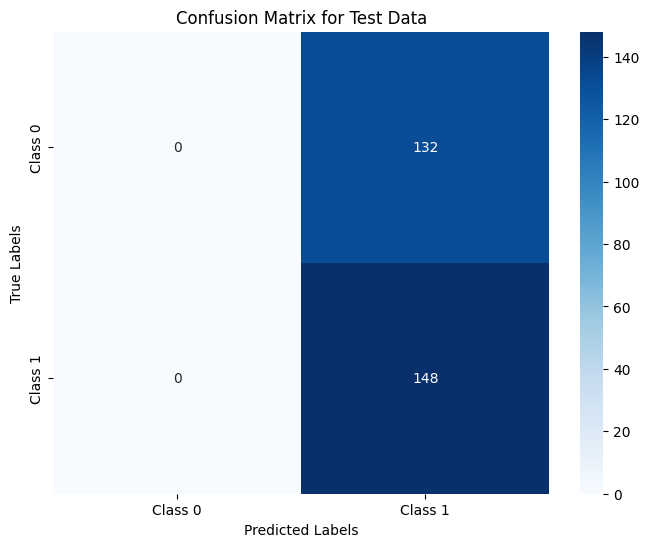

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       132
     Class 1       0.53      1.00      0.69       148

    accuracy                           0.53       280
   macro avg       0.26      0.50      0.35       280
weighted avg       0.28      0.53      0.37       280



In [31]:
# Plot the confusion matrix
plot_confusion_matrix(test_data, predictions, title="Confusion Matrix for Test Data")

# Print the classification report
print_classification_report(test_data, predictions)

# 3.2 Model Layers

In [9]:
print("Model layers: ")
print("********************")
for layer in model.layers:
    print(layer.name)

print("********************")

resnet_model = model.get_layer('resnet101')

print("ResNet layers: ")
print("********************")
for layer in resnet_model.layers:
    print(layer.name)

Model layers: 
********************
resnet101
global_average_pooling2d
dropout
dense
batch_normalization
dropout_1
dense_1
batch_normalization_1
dropout_2
dense_2
dropout_3
dense_3
********************
ResNet layers: 
********************
input_layer
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_b

# 3.3 Visualize Pre-processing Steps

In [10]:
def visualize_preprocessing_steps(image):
    """
    Visualizes all preprocessing steps for a single image.
    
    Args:
        image: Input image to process
    """
    results = preprocess_image(image)
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    titles = ['Original', 'Grayscale', 'Vessels', 'Enhanced', 'Normalized']
    
    for ax, (title, img) in zip(axes, zip(titles, results.values())):
        if len(img.shape) == 3:
            ax.imshow(img)
        else:
            ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

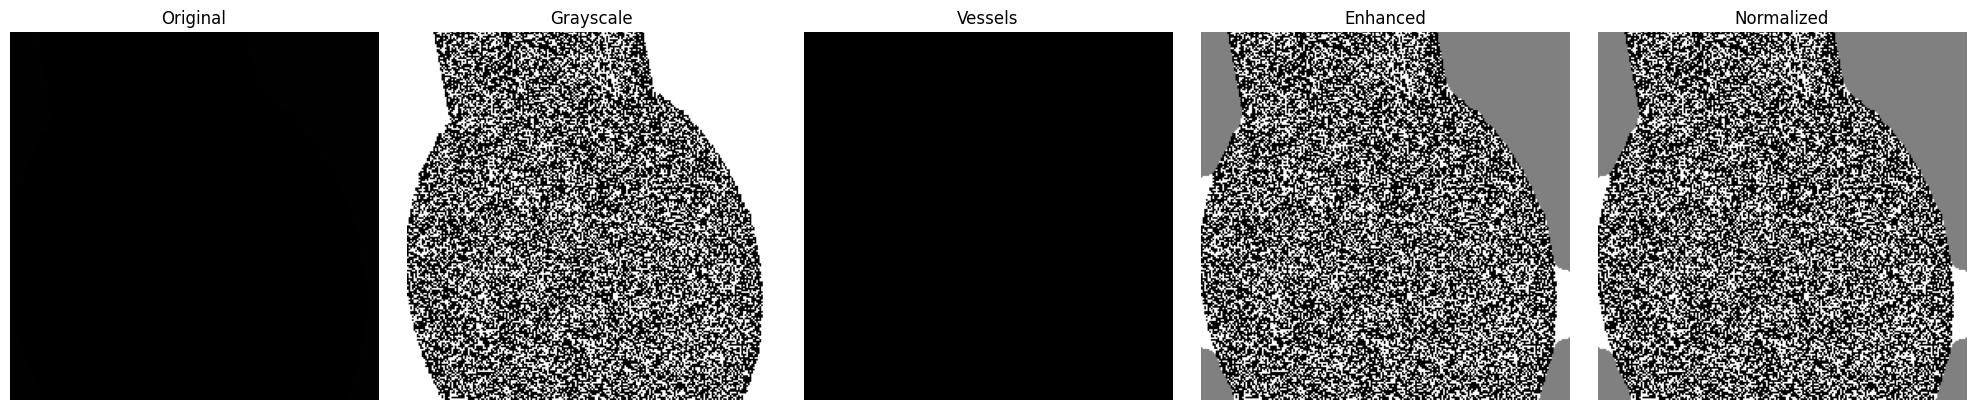

In [17]:
# Get a sample image from your dataset
sample_batch = next(train_data)
sample_image = sample_batch[0][0]  # Get first image from batch

# Convert to uint8 if necessary
if sample_image.dtype != np.uint8:
    sample_image = (sample_image * 255).astype(np.uint8)

# Visualize preprocessing steps
visualize_preprocessing_steps(sample_image)

# 3.4 GradCAM Heatmap

In [12]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


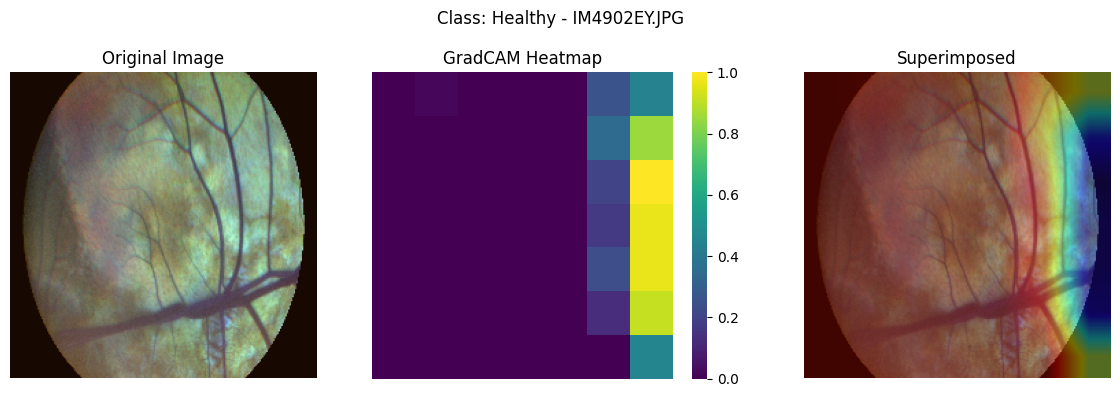

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


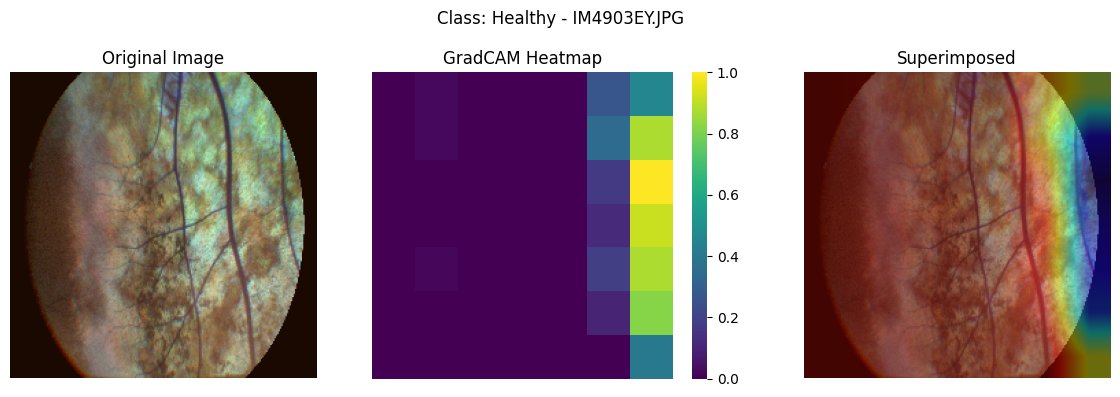

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


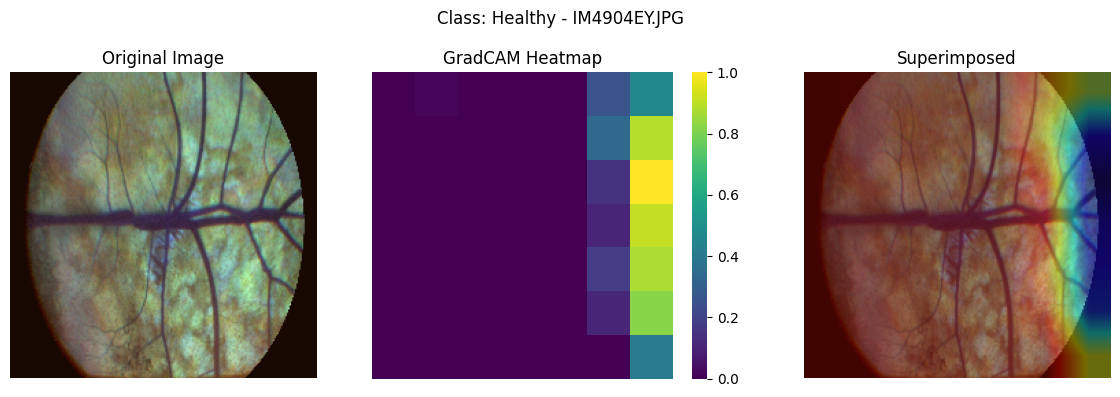

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


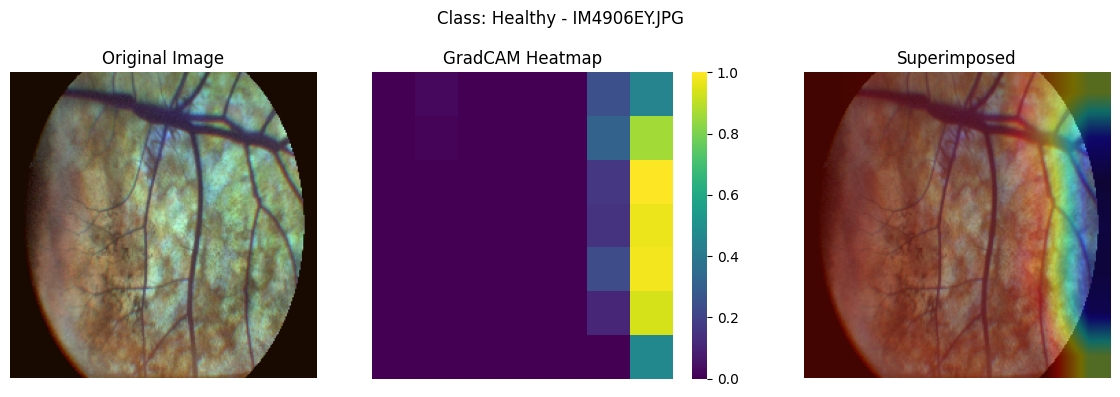

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


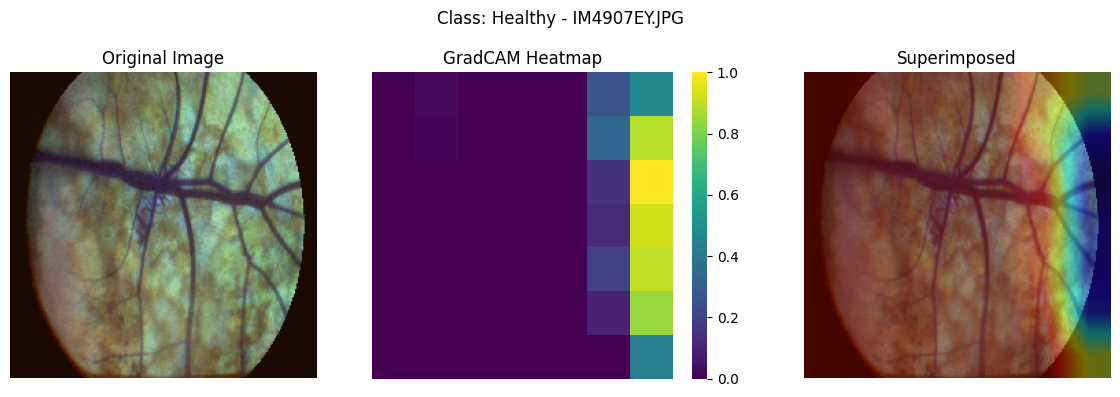

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


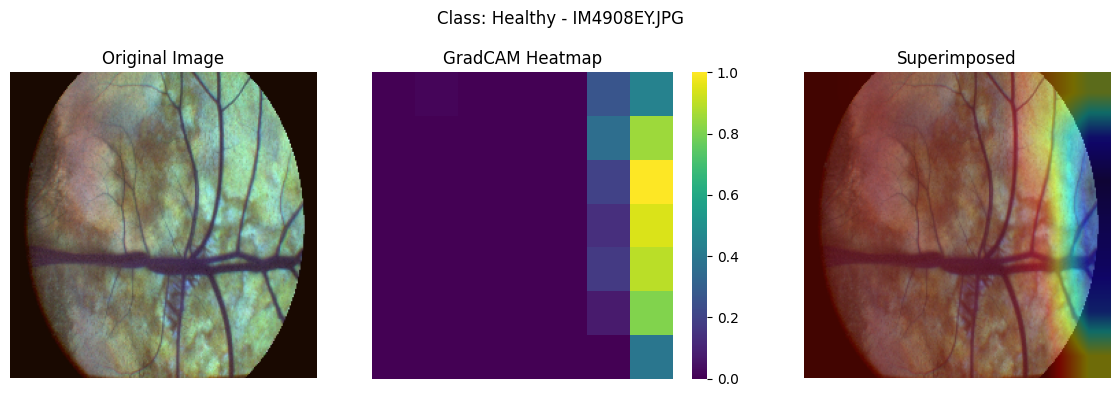

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


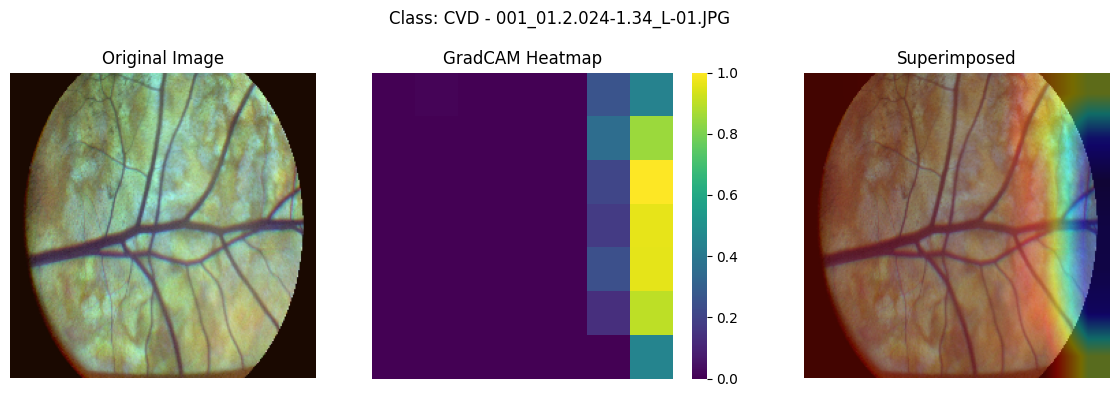

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


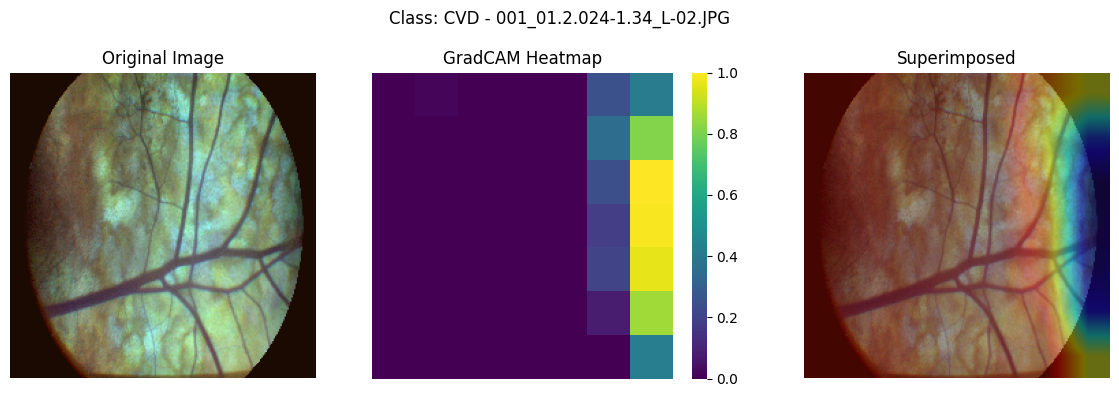

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


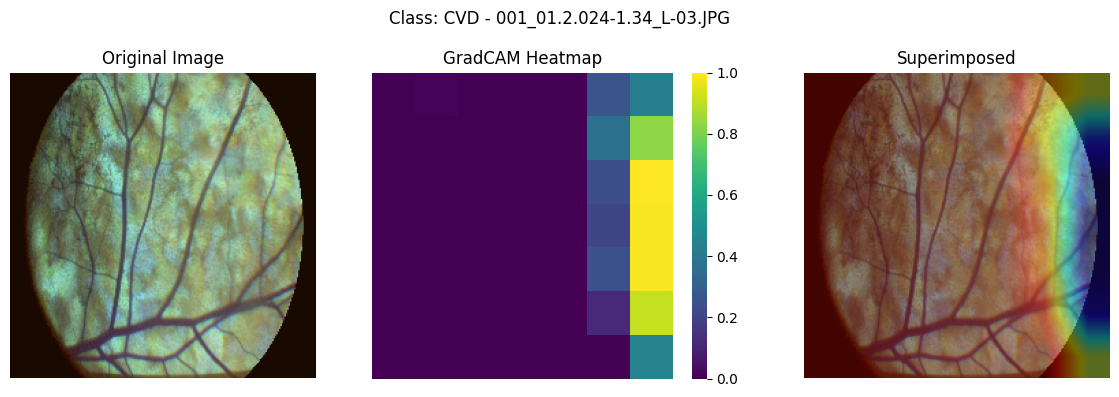

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


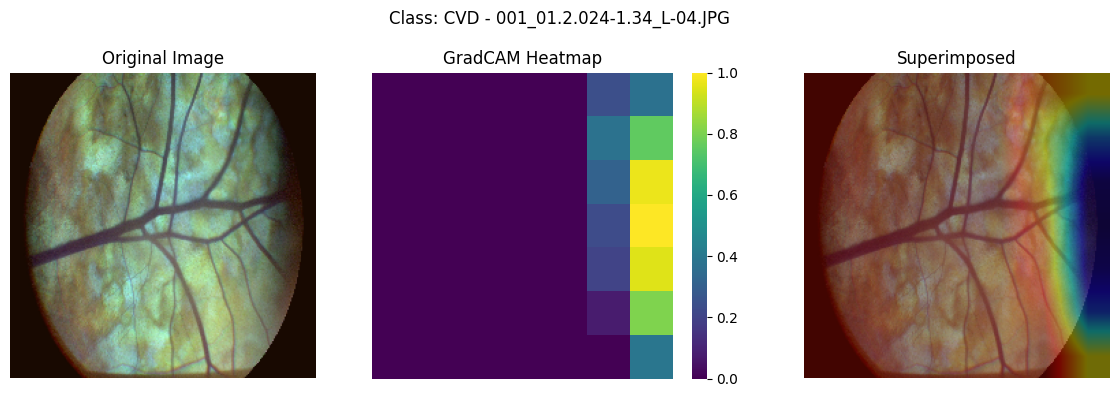

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


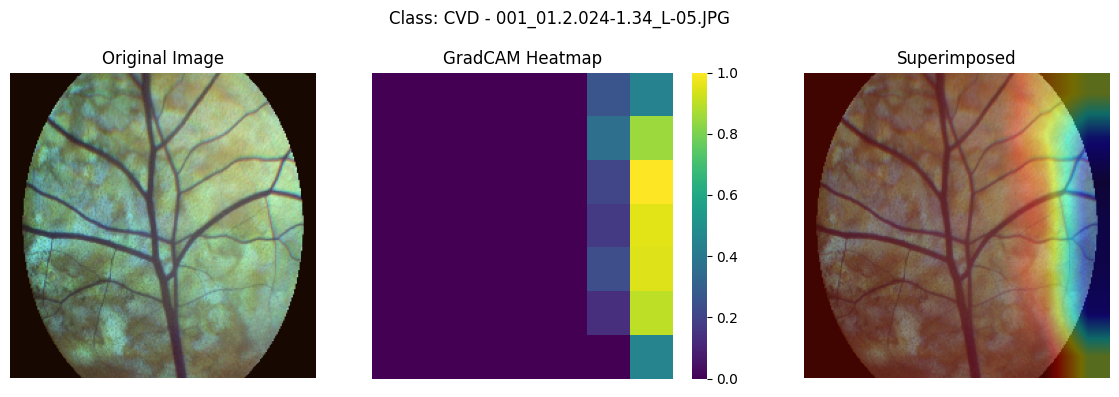

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


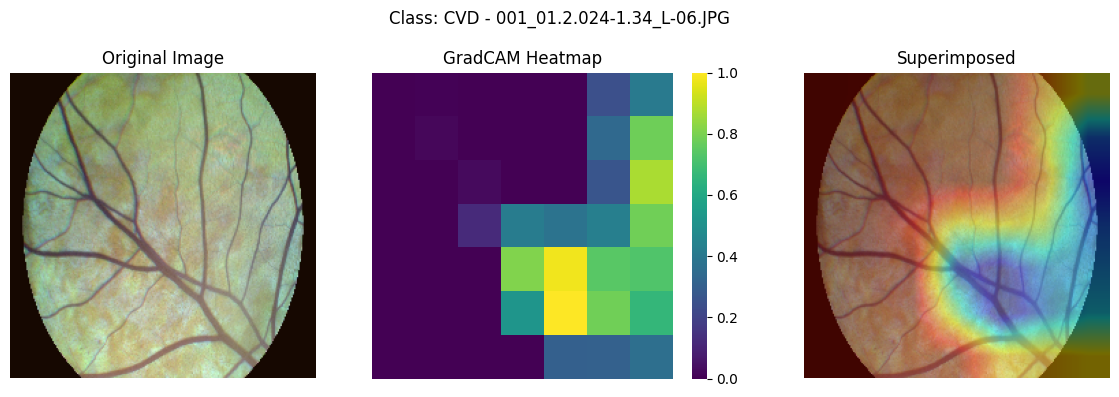

In [13]:
def plot_multiple_gradcam(model, base_path, num_images=6):
    resnet_model = model.get_layer('resnet101')
    last_conv_layer = "conv5_block3_3_conv"
    
    classes = ['0', '1']
    
    for class_name in classes:
        class_path = Path(base_path) / class_name
        image_files = list(class_path.glob('*.JPG'))[:num_images]
        
        for img_path in image_files:
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
            
            # Create Grad-CAM using ResNet base model
            grad_model = tf.keras.models.Model(
                [resnet_model.input],
                [resnet_model.get_layer(last_conv_layer).output, resnet_model.output]
            )
            
            with tf.GradientTape() as tape:
                conv_output, predictions = grad_model(img_array)
                class_channel = predictions[:, :, :, 0]
                
            grads = tape.gradient(class_channel, conv_output)
            pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
            
            conv_output = conv_output[0]
            heatmap = conv_output @ pooled_grads[..., tf.newaxis]
            heatmap = tf.squeeze(heatmap)
            heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
            heatmap = heatmap.numpy()
            
            plt.figure(figsize=(12, 4))
            plt.suptitle(f'Class: {"Healthy" if class_name=="0" else "CVD"} - {img_path.name}')
            
            plt.subplot(131)
            plt.imshow(tf.keras.preprocessing.image.array_to_img(img_array[0]))
            plt.title('Original Image')
            plt.axis('off')
            
            plt.subplot(132)
            sns.heatmap(heatmap, cmap='viridis')
            plt.title('GradCAM Heatmap')
            plt.axis('off')
            
            heatmap_resized = cv2.resize(heatmap, (224, 224))
            heatmap_uint8 = np.uint8(255 * heatmap_resized)
            heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
            
            original_img = tf.keras.preprocessing.image.array_to_img(img_array[0])
            original_array = np.array(original_img)
            superimposed = cv2.addWeighted(original_array, 0.6, heatmap_colored, 0.4, 0)
            
            plt.subplot(133)
            plt.imshow(superimposed)
            plt.title('Superimposed')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()

base_path = Path('../artifacts/dataset/retina_healthy_unhealthy/')
plot_multiple_gradcam(model, base_path)